# LSTM Modelling

On this Notebook, a LSTM Model will be tried for the Competitition Data.

## Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')
from cnr_methods import get_selected_features, transform_data, revert_data,metric_cnr, get_simplified_data
import random

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

## Read Data

Here, the data used correspond to the results of the Feature Engineering and Selection Step. For simplicity, during Hyperparameter Optimization, only Wind Farm 3 Training Data is used.

In [2]:
full_data = get_selected_features(0)

#full_data = full_data.rename({'Unnamed: 0' : 'Time'},axis=1)
full_data = full_data.set_index('Time')

full_label = pd.read_csv('Data/Y_train.csv')
X = full_data[full_data['Set']=='Train']

WF = 'WF3'
X = X[X['WF']==WF]
y = full_label[full_label['ID'].isin(X['ID'])]

In [3]:
X = X.drop(['ID','WF','Set'],axis=1)

In [4]:
X.head()

,U_100m,V_100m,U_10m,V_10m,T,CLCT,Wind Direction 100m,Wind Direction 10m,Wind Speed 100m,V_100m_lag_21_days,...,V_10m_Rolling_14_Window_Variance,U_100m_Rolling_14_Window_Mean,Wind Speed 10m,V_100m_Rolling_7_Window_Mean,T_lag_21_days,U_10m_Rolling_14_Window_Variance,CLCT_Rolling_7_Window_Mean,V_100m_lag_7_days,U_10m_lag_7_days,U_100m_lag_21_days
Time,,,,,,,,,,,,,,,,,,,,,
2018-05-01 01:00:00,5.789500,3.820200,1.054669,1.317597,275.690,86.504507,0.583268,0.895782,6.936299,NaN,...,NaN,NaN,1.687717,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01 02:00:00,6.003300,3.920600,0.876879,1.483483,275.770,98.976088,0.578533,1.036951,7.170127,NaN,...,NaN,NaN,1.723264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01 03:00:00,5.931829,0.907656,0.949640,1.419591,276.875,64.193607,0.151837,0.981212,6.000870,NaN,...,NaN,NaN,1.707938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01 04:00:00,5.205300,1.683800,1.027462,1.029786,275.650,57.482484,0.312855,0.786528,5.470862,NaN,...,NaN,NaN,1.454695,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01 05:00:00,4.845900,0.702200,1.011645,0.785352,275.530,89.971463,0.143904,0.660129,4.896512,NaN,...,NaN,NaN,1.280704,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Scaling Data

In [5]:
scaler = MinMaxScaler(feature_range=(-1,1))
X = scaler.fit_transform(X)
X = pd.DataFrame(X)

In [6]:
y = scaler.fit_transform(y)
y = pd.DataFrame(y)

In [7]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,0.228968,0.130650,-0.080167,0.046187,-0.652228,0.730090,-0.996765,-0.995041,-0.235387,NaN,...,NaN,NaN,-0.710735,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.243537,0.136909,-0.099786,0.062691,-0.648044,0.979522,-0.996792,-0.994256,-0.209145,NaN,...,NaN,NaN,-0.704468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.238667,-0.050938,-0.091757,0.056334,-0.590239,0.283872,-0.999162,-0.994566,-0.340364,NaN,...,NaN,NaN,-0.707170,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.189158,-0.002548,-0.083169,0.017554,-0.654321,0.149650,-0.998268,-0.995648,-0.399844,NaN,...,NaN,NaN,-0.751810,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.164667,-0.063747,-0.084914,-0.006764,-0.660598,0.799429,-0.999206,-0.996350,-0.464300,NaN,...,NaN,NaN,-0.782480,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
y

,0,1
0,-1.000000,-0.778768
1,-0.999679,-0.631774
2,-0.999359,-0.671863
3,-0.999038,-0.778768
4,-0.998718,-0.814402
...,...,...
6234,0.998718,-0.768374
6235,0.999038,-0.808463
6236,0.999359,-0.867854
6237,0.999679,-0.839644


## Subsets Creation

Convert Df's to Array on Correct Shape

In [9]:
n_steps = 3

In [10]:
# split a multivariate sequence into samples
def split_sequences(X, y, n_steps):
	sample_X, sample_y = list(), list()
	for i in range(len(X)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(X):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = X[i:end_ix, :-1], y[end_ix-1,-1]
		sample_X.append(seq_x)
		sample_y.append(seq_y)
	return np.array(sample_X), np.array(sample_y)

In [11]:
sample_X,sample_y = split_sequences(X.values,y.values,n_steps)

In [12]:
n_features = sample_X.shape[2]

## Model

Model Creation Function:

In [13]:
def LSTM_Model(input_shape):
  # Numerical branch

  input_layer = tf.keras.layers.Input(input_shape)

  hidden_1 = tf.keras.layers.LSTM(units=1024, activation="relu", kernel_initializer="he_normal")(input_layer)
  hidden_1 = tf.keras.layers.Dropout(rate=0.3)(hidden_1)
  #hidden_1 = tf.keras.layers.BatchNormalization()(hidden_1)

  # Output

  #outputs = tf.keras.layers.PReLU()(hidden_1)
  #outputs = tf.keras.layers.Dropout(rate=0.3)(outputs)
  #outputs = tf.keras.layers.BatchNormalization()(outputs)
  outputs = tf.keras.layers.Dense(units=1, activation="relu")(hidden_1)

  model = tf.keras.Model(inputs=input_layer, outputs=outputs)

  return model

In [14]:
input_shape = (n_steps,n_features)

In [15]:
model = LSTM_Model(input_shape)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 92)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1024)              4575232   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 4,576,257
Trainable params: 4,576,257
Non-trainable params: 0
_________________________________________________________________


## Validation

In [17]:
def metric_cnr(preds,labels):
    cape_cnr = 100*np.sum(np.abs(preds-labels))/np.sum(labels)
    return 'CAPE', cape_cnr

In [18]:
def metric_cnr(preds,labels):
    cape_cnr = 100*tf.math.reduce_sum(tf.math.abs(preds-labels))/tf.math.reduce_sum(labels)
    return cape_cnr

In [19]:
random.seed(317)
tf.random.set_seed(317)

patience = 10
epochs = 40
k_fold_splits = 5
total_it = 120
monitor = "root_mean_squared_error"
batch_size = 1 * ((len(X) - len(X) // k_fold_splits) // (total_it))

In [20]:
# Define Time Split Cross Validation
tscv = TimeSeriesSplit(n_splits=k_fold_splits)

# Separating Data from Hold Out Set

X_cv, _, y_cv, _ = train_test_split(X, y, test_size=0.125, shuffle=False)

train_scores = np.empty(0)
val_scores = np.empty(0)
test_scores = np.empty(0)
for train_index, test_index in tscv.split(X_cv):

    # Get the Data of the Split
    X_train, X_test = X_cv.iloc[train_index], X_cv.iloc[test_index]
    y_train, y_test = y_cv.iloc[train_index], y_cv.iloc[test_index]

    # Separating Training Set of Split on Train and Validation Subsets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

    # Reshape Data
    X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
    X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
    X_test, y_test = split_sequences(X_test.values,y_test.values,n_steps)

    # Create Model
    model = LSTM_Model(input_shape)

    # Callbacks
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]

    # Train the Model
    model.compile(optimizer='adam', loss='hinge', metrics=[tf.keras.metrics.RootMeanSquaredError(),metric_cnr])
    history = model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list)

    # Train and Validation Score
    train_score = np.array(history.history['metric_cnr']).mean()
    val_score = np.array(history.history['val_metric_cnr']).mean()

    # Test Score
    preds = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    test_score = metric_cnr(preds,y_test)

    train_scores = np.append(train_scores,train_score)
    val_scores = np.append(val_scores,val_score)
    test_scores = np.append(test_scores,test_score)

Epoch 1/40
20/20 [==============================] - 2s 79ms/step - loss: nan - root_mean_squared_error: nan - metric_cnr: nan - val_loss: nan - val_root_mean_squared_error: nan - val_metric_cnr: nan
Epoch 2/40
20/20 [==============================] - 1s 66ms/step - loss: nan - root_mean_squared_error: nan - metric_cnr: nan - val_loss: nan - val_root_mean_squared_error: nan - val_metric_cnr: nan
Epoch 3/40
20/20 [==============================] - 1s 66ms/step - loss: nan - root_mean_squared_error: nan - metric_cnr: nan - val_loss: nan - val_root_mean_squared_error: nan - val_metric_cnr: nan
Epoch 4/40
20/20 [==============================] - 1s 67ms/step - loss: nan - root_mean_squared_error: nan - metric_cnr: nan - val_loss: nan - val_root_mean_squared_error: nan - val_metric_cnr: nan
Epoch 5/40
20/20 [==============================] - 1s 66ms/step - loss: nan - root_mean_squared_error: nan - metric_cnr: nan - val_loss: nan - val_root_mean_squared_error: nan - val_metric_cnr: nan
Epoch

In [21]:
train_scores

array([nan, nan, nan, nan, nan])

### Hold Out Score

In [22]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.125, shuffle=False)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

In [24]:
X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
X_holdout, y_holdout = split_sequences(X_holdout.values,y_holdout.values,n_steps)

In [25]:
model = LSTM_Model(input_shape)

In [26]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
model.compile(optimizer='adam', loss='hinge', metrics=[tf.keras.metrics.RootMeanSquaredError(),metric_cnr])
model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list)

Epoch 1/40
115/115 [==============================] - 8s 68ms/step - loss: nan - root_mean_squared_error: nan - metric_cnr: nan - val_loss: nan - val_root_mean_squared_error: nan - val_metric_cnr: nan
Epoch 2/40
115/115 [==============================] - 8s 68ms/step - loss: nan - root_mean_squared_error: nan - metric_cnr: nan - val_loss: nan - val_root_mean_squared_error: nan - val_metric_cnr: nan
Epoch 3/40
115/115 [==============================] - 8s 68ms/step - loss: nan - root_mean_squared_error: nan - metric_cnr: nan - val_loss: nan - val_root_mean_squared_error: nan - val_metric_cnr: nan
Epoch 4/40
115/115 [==============================] - 8s 70ms/step - loss: nan - root_mean_squared_error: nan - metric_cnr: nan - val_loss: nan - val_root_mean_squared_error: nan - val_metric_cnr: nan
Epoch 5/40
115/115 [==============================] - 7s 65ms/step - loss: nan - root_mean_squared_error: nan - metric_cnr: nan - val_loss: nan - val_root_mean_squared_error: nan - val_metric_cnr:

In [27]:
preds = model.predict(X_holdout,batch_size = batch_size,callbacks=callbacks_list)

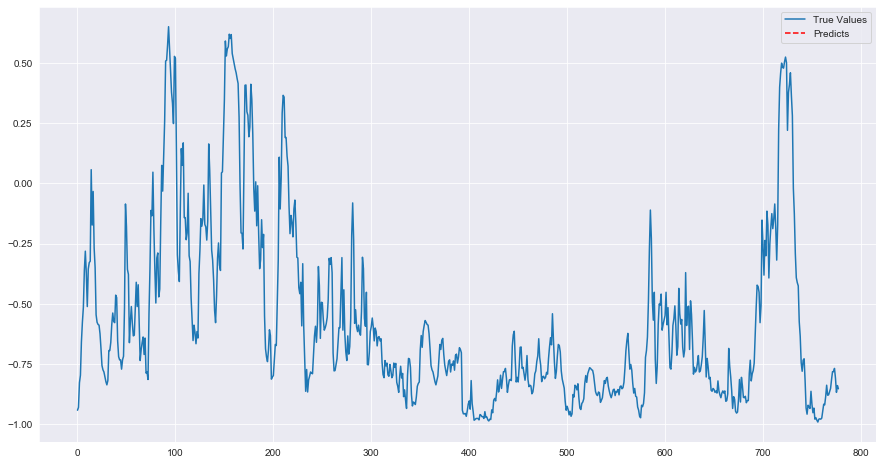

In [28]:
plt.figure(figsize=(15,8))
preds_len = np.arange(len(y_holdout))
plt.plot(preds_len,y_holdout,label='True Values')
plt.plot(preds_len,preds,'r--',label='Predicts')
plt.legend()